Import the important Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Import various models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # Added AdaBoost
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # Added KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # Added Decision Tree Classifier

# Import TensorFlow and Keras for Neural Networks
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow and Keras imported successfully.")
except ImportError:
    print("TensorFlow not installed. Skipping Neural Network models.")
    tf = None # Set tf to None if not available

TensorFlow and Keras imported successfully.


In [6]:
import warnings
# Suppress specific FutureWarning from Seaborn for palette without hue
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Load the datasets

In [2]:
# Load the datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission_df = pd.read_csv('sample_submission.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure 'train.csv', 'test.csv', and 'sample_submission.csv' are in the same directory.")
    exit()

Datasets loaded successfully.


In [17]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#Exploratory Data Analysis (EDA) ---


In [3]:
print("\n--- EDA: Training Data Info ---")
train_df.info()
print("\n--- EDA: Training Data Description ---")
print(train_df.describe(include='all'))
print("\n--- EDA: Missing Values in Training Data ---")
print(train_df.isnull().sum())
print("\n--- EDA: Missing Values in Test Data ---")
print(test_df.isnull().sum())


--- EDA: Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

--- EDA: Training Data Description ---
       PassengerId HomePlanet CryoSleep    Cabin  Destination        

Visualize 'Transported' (target variable) distribution

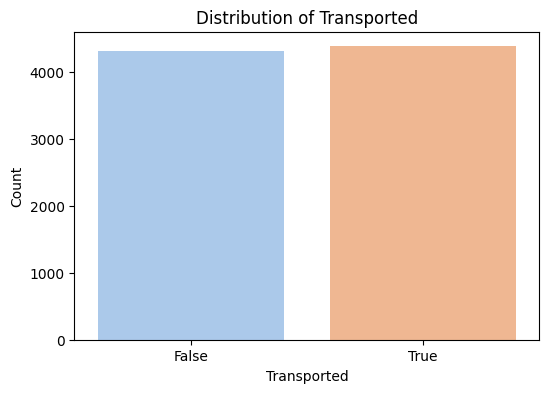

In [10]:
# Visualize 'Transported' (target variable) distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df, hue='Transported', palette='pastel', legend=False)
plt.title('Distribution of Transported')
plt.ylabel('Count')
plt.show()

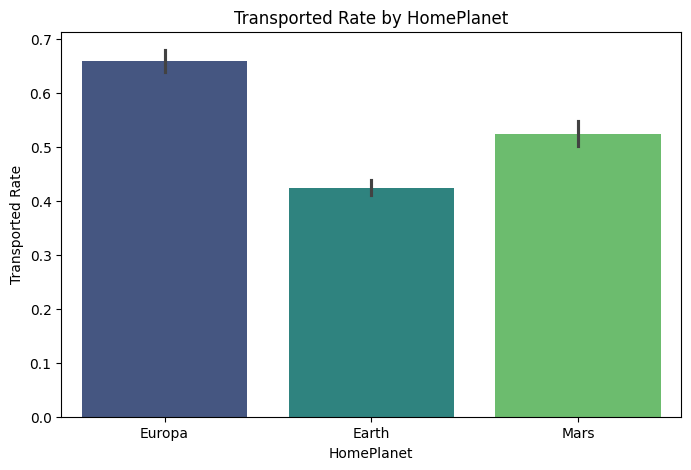

In [11]:
# Visualize 'Transported' rate by 'HomePlanet'
plt.figure(figsize=(8, 5))
sns.barplot(x='HomePlanet', y='Transported', data=train_df, palette='viridis', hue='HomePlanet', legend=False)
plt.title('Transported Rate by HomePlanet')
plt.ylabel('Transported Rate')
plt.show()

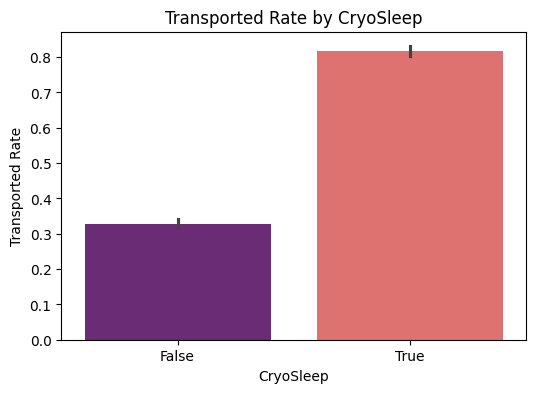

In [12]:
# Visualize 'Transported' rate by 'CryoSleep'
plt.figure(figsize=(6, 4))
sns.barplot(x='CryoSleep', y='Transported', data=train_df, palette='magma', hue='CryoSleep', legend=False)
plt.title('Transported Rate by CryoSleep')
plt.ylabel('Transported Rate')
plt.show()

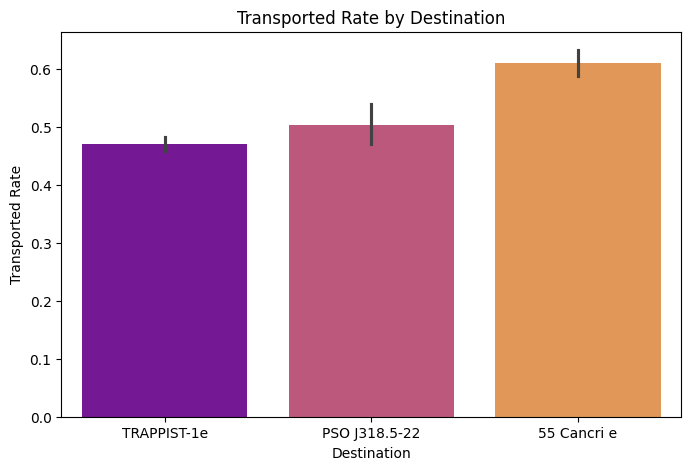

In [13]:
# Visualize 'Transported' rate by 'Destination'
plt.figure(figsize=(8, 5))
sns.barplot(x='Destination', y='Transported', data=train_df, palette='plasma', hue='Destination', legend=False)
plt.title('Transported Rate by Destination')
plt.ylabel('Transported Rate')
plt.show()

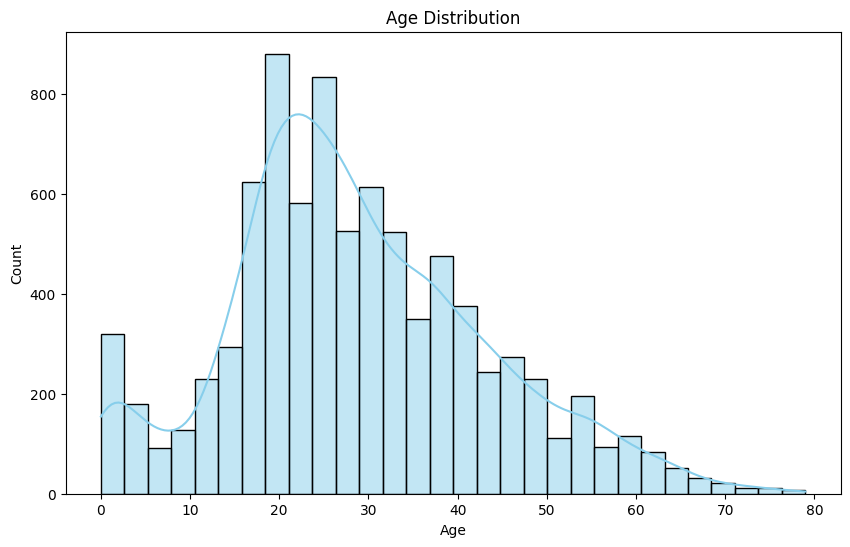

In [14]:
# Visualize Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

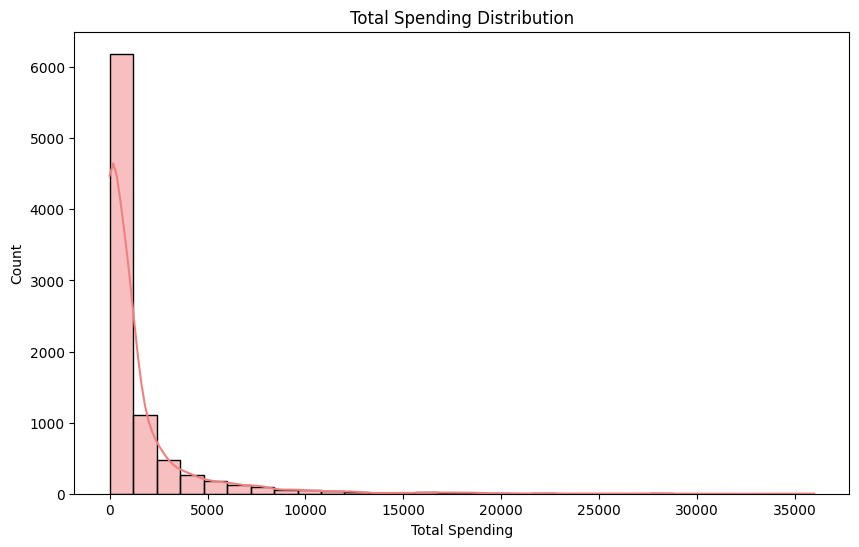

In [15]:
# Visualize total spending (sum of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)
train_df['TotalSpending'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['TotalSpending'].dropna(), bins=30, kde=True, color='lightcoral')
plt.title('Total Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Count')
plt.show()

In [16]:
# Drop the temporary 'TotalSpending' column from train_df to avoid affecting the original df for preprocessing
train_df = train_df.drop('TotalSpending', axis=1)

#Data Preprocessing

In [18]:
# --- 2. Data Preprocessing ---

# Store PassengerId for submission later
passenger_ids = test_df['PassengerId']

# Separate 'Transported' from train_df
train_labels = train_df['Transported'].astype(int) # Convert boolean to int (True=1, False=0)
train_features = train_df.drop('Transported', axis=1)

# Concatenate train_features and test_df for consistent feature engineering and imputation
combined_df = pd.concat([train_features, test_df], ignore_index=True)

# Drop features that are not useful or have too many unique values
combined_df = combined_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1)

# Define categorical and numerical features for preprocessing pipeline
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Create preprocessing pipelines for numerical and categorical features
# Added StandardScaler for numerical features, as it can benefit models like Logistic Regression and SVM
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with the mean
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with the most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the combined dataset
print("\nApplying preprocessing to combined data...")
combined_df_preprocessed = preprocessor.fit_transform(combined_df)
print("Preprocessing complete.")

# Split back into original training features and test features
X_original_train_processed = combined_df_preprocessed[:len(train_df)]
X_test_processed = combined_df_preprocessed[len(train_df):]
y_original_train = train_labels

print(f"\nShape of original preprocessed training data: {X_original_train_processed.shape}")
print(f"Shape of preprocessed test data: {X_test_processed.shape}")
print(f"Shape of original training labels: {y_original_train.shape}")


Applying preprocessing to combined data...
Preprocessing complete.

Shape of original preprocessed training data: (8693, 16)
Shape of preprocessed test data: (4277, 16)
Shape of original training labels: (8693,)


Correlation map for numerical attributes

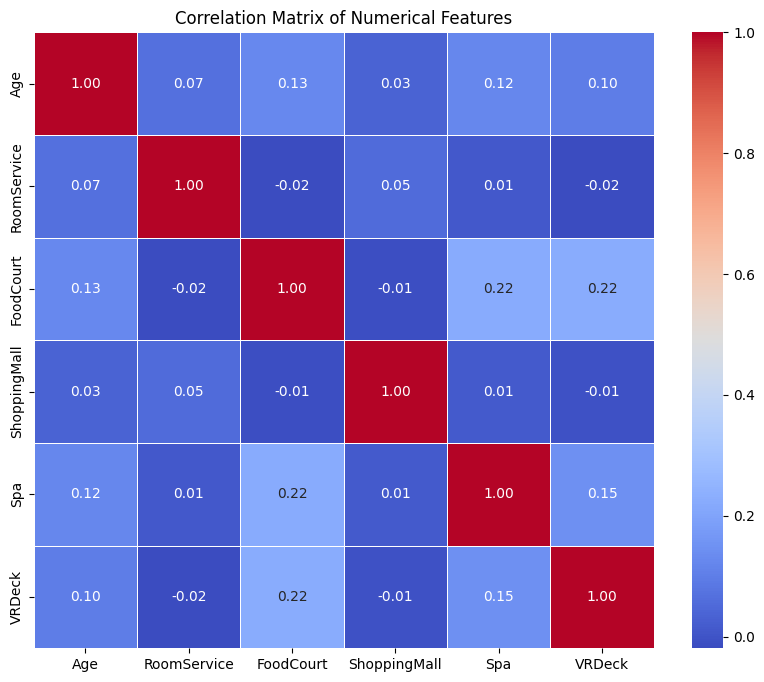

In [20]:
# Create a DataFrame from the preprocessed numerical features
numerical_df_processed = pd.DataFrame(X_original_train_processed[:, :len(numerical_features)], columns=numerical_features)

# Calculate the correlation matrix
correlation_matrix = numerical_df_processed.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Correlation for all attributes


--- Generating Heatmap for Preprocessed Features ---


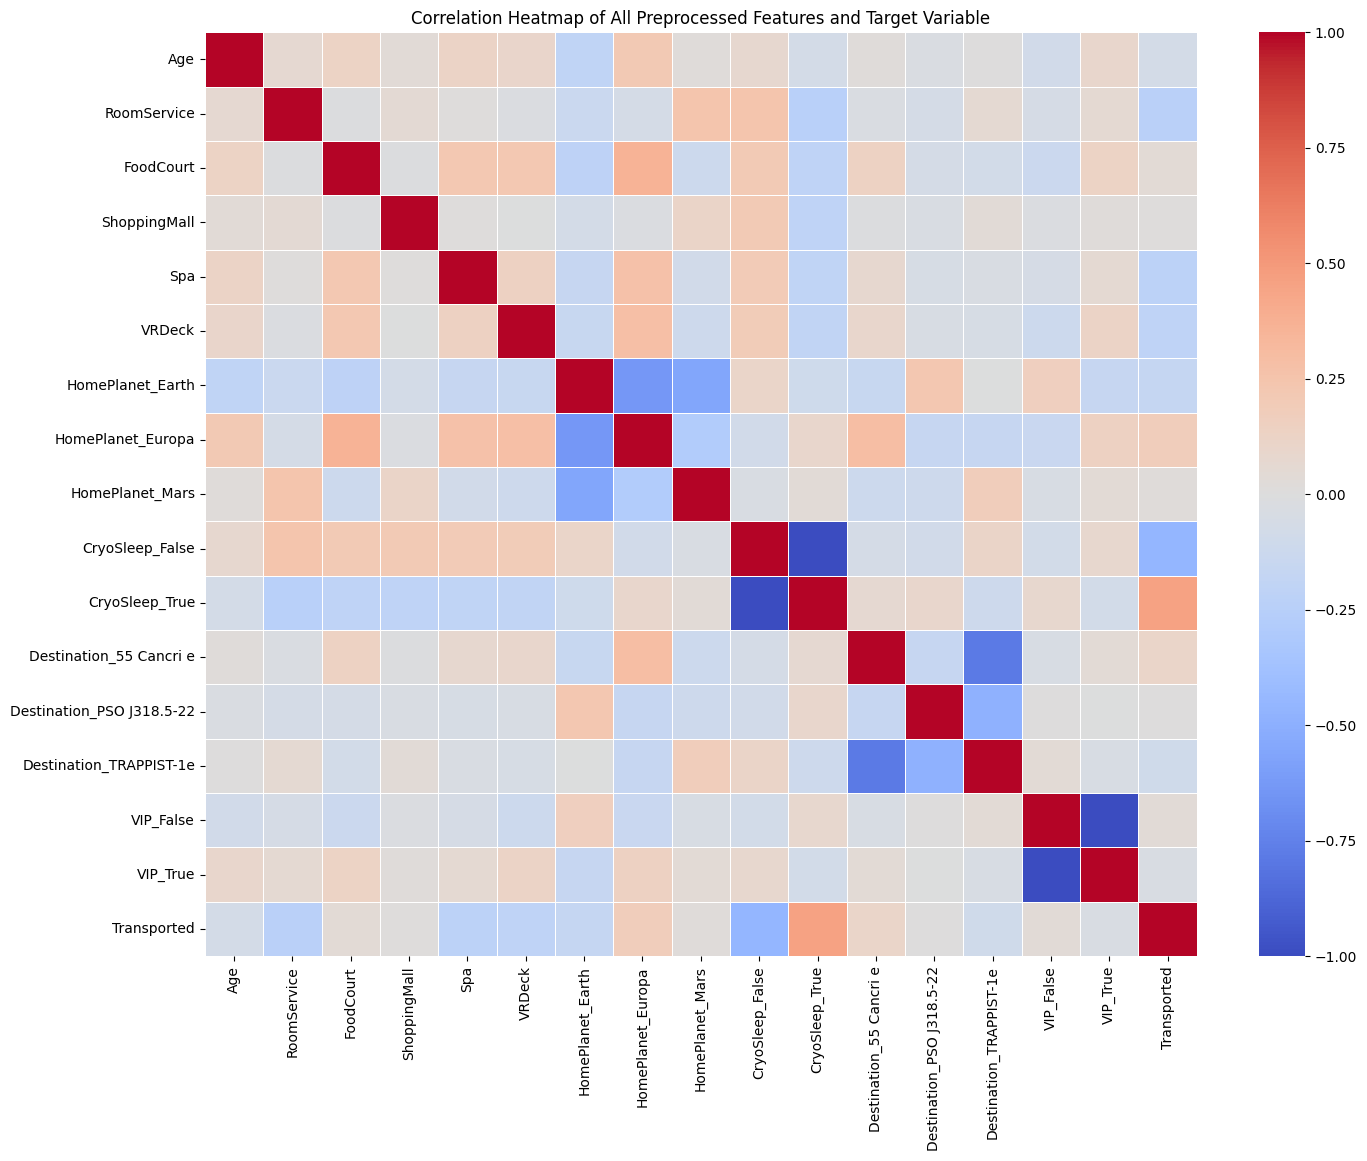

Heatmap generated.


In [21]:
# --- Heatmap for all preprocessed columns ---
print("\n--- Generating Heatmap for Preprocessed Features ---")

# Get feature names after one-hot encoding
# This part can be tricky with ColumnTransformer if we don't know the order.
# A more robust way is to get names from the OneHotEncoder step.
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame from the preprocessed training data for correlation calculation
X_train_df_for_corr = pd.DataFrame(X_original_train_processed, columns=all_feature_names)

# Add the target variable back to this DataFrame for correlation with features
X_train_df_for_corr['Transported'] = y_original_train

# Calculate the correlation matrix
correlation_matrix = X_train_df_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of All Preprocessed Features and Target Variable')
plt.show()
print("Heatmap generated.")

In [22]:
# --- 3. Model Training and Validation for Multiple Models ---

# Split the original training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_original_train_processed, y_original_train, test_size=0.2, random_state=42, stratify=y_original_train
)

print(f"\nShape of actual training data for model: {X_train.shape}")
print(f"Shape of validation data: {X_test.shape}")


Shape of actual training data for model: (6954, 16)
Shape of validation data: (1739, 16)


Different Models Implementation
KNN, AdaBoost, Random Forest, Decision Tree, Support Vector Machine, Logistic Regression, XGBoost, ANN, CNN

In [64]:
# Define a dictionary of models to train with specific hyperparameters
models = {
    # KNN
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7), #  hyperparameter: n_neighbors
    # AdaBoost
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42), #  hyperparameters
    # Random Forest
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, class_weight='balanced'), # hyperparameters
    # Decision Tree
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42), #  hyperparameters
    # Support Vector Machine (SVM)
    'Support Vector Machine': SVC(C=1.0, kernel='rbf', probability=True, random_state=42), # hyperparameters

    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear')
}



========== Training K-Nearest Neighbors ==========
K-Nearest Neighbors Model training complete on training split.

Training Accuracy: 0.8167
Validation Accuracy: 0.7677
Precision: 0.7700
Recall: 0.7683
F1-score: 0.7691

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       863
           1       0.77      0.77      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



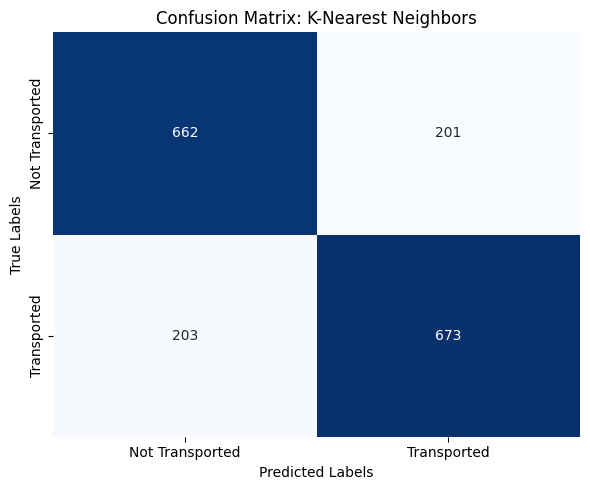


========== Training AdaBoost ==========
AdaBoost Model training complete on training split.

Training Accuracy: 0.7764
Validation Accuracy: 0.7654
Precision: 0.8008
Recall: 0.7112
F1-score: 0.7533

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       863
           1       0.80      0.71      0.75       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.76      1739
weighted avg       0.77      0.77      0.76      1739



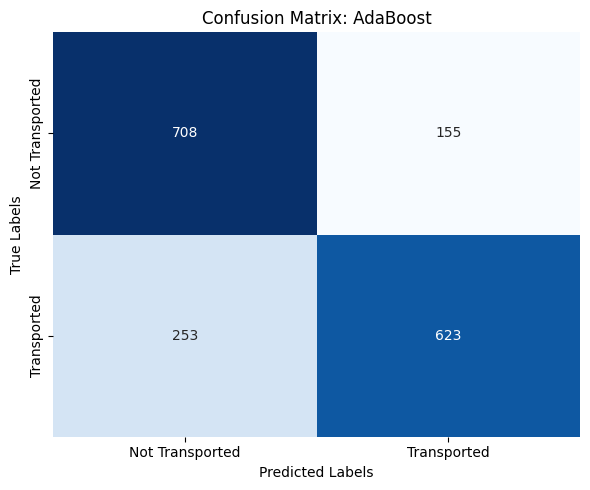


========== Training Random Forest ==========
Random Forest Model training complete on training split.

Training Accuracy: 0.8414
Validation Accuracy: 0.7936
Precision: 0.7921
Recall: 0.8002
F1-score: 0.7961

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       863
           1       0.79      0.80      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



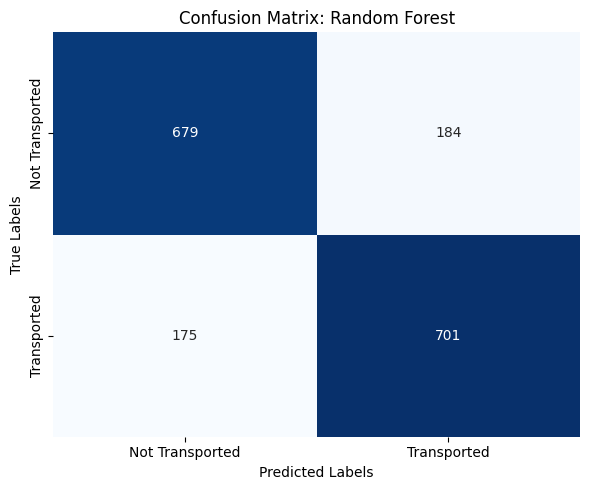


========== Training Decision Tree ==========
Decision Tree Model training complete on training split.

Training Accuracy: 0.8033
Validation Accuracy: 0.7861
Precision: 0.7614
Recall: 0.8379
F1-score: 0.7978

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       863
           1       0.76      0.84      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



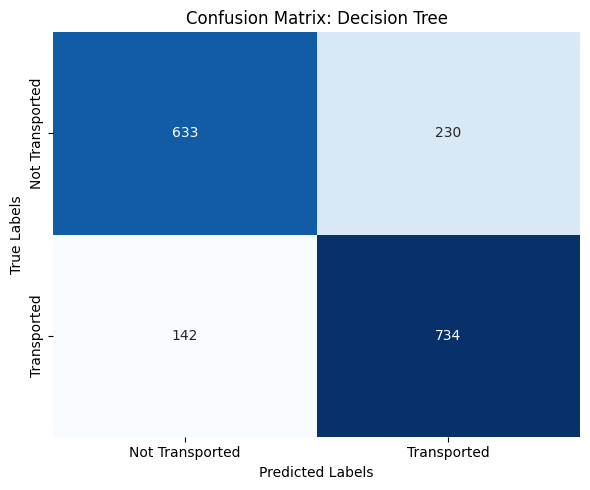


========== Training Support Vector Machine ==========
Support Vector Machine Model training complete on training split.

Training Accuracy: 0.7959
Validation Accuracy: 0.7757
Precision: 0.7949
Recall: 0.7477
F1-score: 0.7706

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       863
           1       0.79      0.75      0.77       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



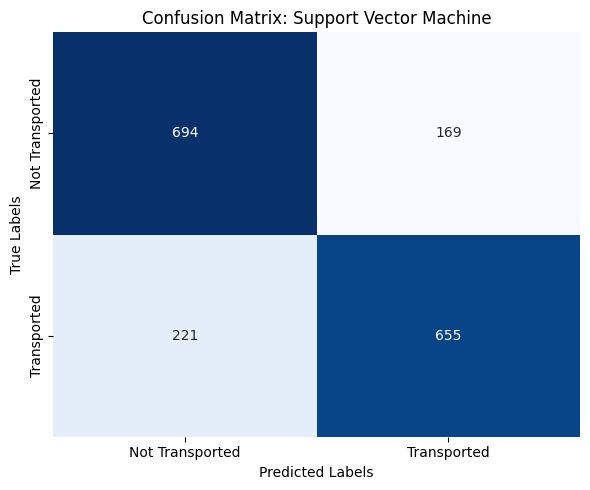


========== Training Logistic Regression ==========
Logistic Regression Model training complete on training split.

Training Accuracy: 0.7852
Validation Accuracy: 0.7884
Precision: 0.7920
Recall: 0.7865
F1-score: 0.7892

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       863
           1       0.79      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



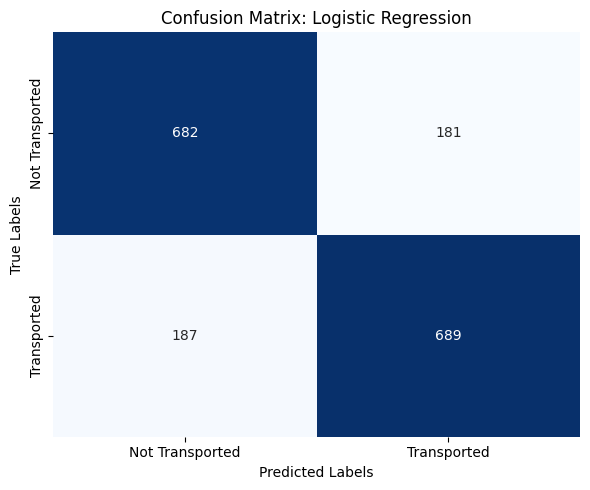


--- Model Comparison Results ---
K-Nearest Neighbors: Train Acc = 0.8167, Val Acc = 0.7677, Precision = 0.7700, Recall = 0.7683, F1 = 0.7691
AdaBoost: Train Acc = 0.7764, Val Acc = 0.7654, Precision = 0.8008, Recall = 0.7112, F1 = 0.7533
Random Forest: Train Acc = 0.8414, Val Acc = 0.7936, Precision = 0.7921, Recall = 0.8002, F1 = 0.7961
Decision Tree: Train Acc = 0.8033, Val Acc = 0.7861, Precision = 0.7614, Recall = 0.8379, F1 = 0.7978
Support Vector Machine: Train Acc = 0.7959, Val Acc = 0.7757, Precision = 0.7949, Recall = 0.7477, F1 = 0.7706
Logistic Regression: Train Acc = 0.7852, Val Acc = 0.7884, Precision = 0.7920, Recall = 0.7865, F1 = 0.7892


In [65]:
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    # All remaining models are scikit-learn models
    model.fit(X_train, y_train)
    print(f"{name} Model training complete on training split.\n")

    # Predict on validation set
    y_pred = model.predict(X_test)

    # Evaluate accuracy on the training split
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Evaluate accuracy on the validation set
    val_accuracy = accuracy_score(y_test, y_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}") # Renamed to Validation Accuracy for clarity

    # Calculate and print additional metrics for all models
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Not Transported', 'Transported'],
                yticklabels=['Not Transported', 'Transported'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

    results[name] = {'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy,
                     'precision': precision, 'recall': recall, 'f1_score': f1}

print("\n--- Model Comparison Results ---")
for name, metrics in results.items():
    print(f"{name}: Train Acc = {metrics['train_accuracy']:.4f}, Val Acc = {metrics['val_accuracy']:.4f}, "
          f"Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, F1 = {metrics['f1_score']:.4f}")

## Summarize results

### Subtask:
Summarize the performance metrics (Accuracy, Precision, Recall, and F1 Score) of all trained models.


**Reasoning**:
Summarize the performance metrics of all trained models by creating a pandas DataFrame from the `results` dictionary and displaying it.



In [ ]:
print("\n--- Model Comparison Results ---")
for name, metrics in results.items():
    print(f"{name}: Train Acc = {metrics['train_accuracy']:.4f}, Val Acc = {metrics['val_accuracy']:.4f}, "
          f"Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, F1 = {metrics['f1_score']:.4f}")


In [66]:
# Summarize the performance metrics
results_df = pd.DataFrame(results).T # Transpose to have models as rows and metrics as columns
print("\n--- Model Performance Summary ---")
display(results_df)


--- Model Performance Summary ---


,train_accuracy,val_accuracy,precision,recall,f1_score
K-Nearest Neighbors,0.816652,0.767683,0.770023,0.768265,0.769143
AdaBoost,0.776388,0.765382,0.800771,0.711187,0.753325
Random Forest,0.841386,0.793560,0.792090,0.800228,0.796139
Decision Tree,0.803279,0.786084,0.761411,0.837900,0.797826
Support Vector Machine,0.795945,0.775733,0.794903,0.747717,0.770588
Logistic Regression,0.785160,0.788384,0.791954,0.786530,0.789233


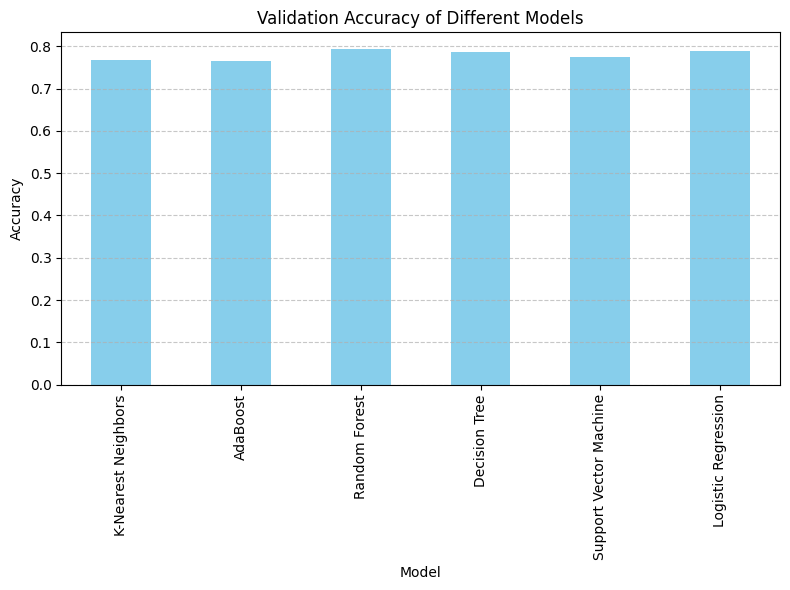

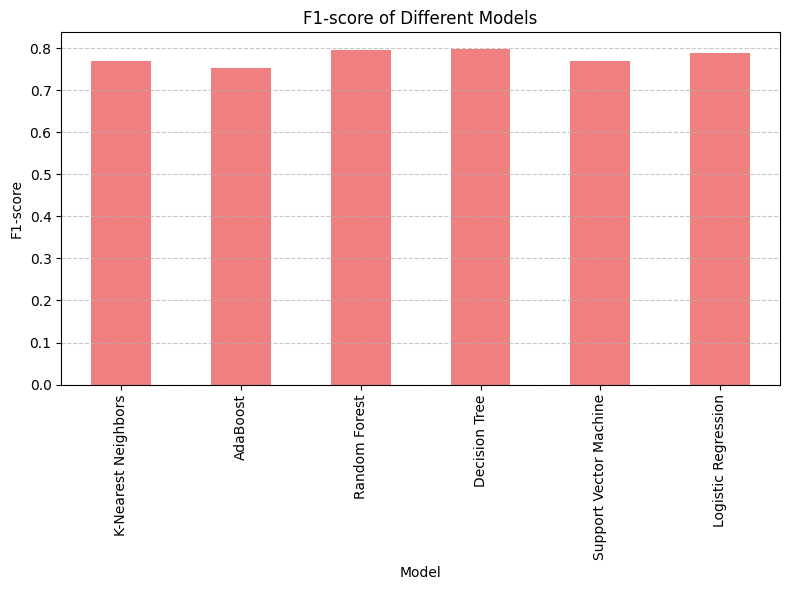

In [69]:
# Plotting Validation Accuracy
plt.figure(figsize=(8, 6))
results_df['val_accuracy'].plot(kind='bar', color='skyblue')
plt.title('Validation Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=90) # Rotate x-axis labels vertically
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting F1-score
plt.figure(figsize=(8, 6))
results_df['f1_score'].plot(kind='bar', color='lightcoral')
plt.title('F1-score of Different Models')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.xticks(rotation=90) # Rotate x-axis labels vertically
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Select best model

### Subtask:
Identify the best performing model based on the summarized performance metrics, focusing on a relevant metric like F1-score or Accuracy, depending on the problem context.


**Reasoning**:
Examine the results_df and identify the best model based on Accuracy Score, then store the name of the best model and the model object.



In [73]:
# Identify the best performing model based on F1 Score
best_model_name = results_df['val_accuracy'].idxmax()
best_model = models[best_model_name]

print(f"\nBest performing model based on Accuracy Score: {best_model_name}")


Best performing model based on Accuracy Score: Random Forest


In [78]:
best_model

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150,
                       random_state=42)

## Make predictions and create submission file

### Subtask:
Use the best model to make predictions on the test data and generate a submission file in the specified format.


**Reasoning**:
Use the best model to predict on the test data, convert predictions to boolean, create the submission dataframe, and save it to a CSV file.



In [74]:
# Use the best model to make predictions on the test data
# For Keras models, prediction gives probabilities, need to convert to class labels (0 or 1)
if best_model_name in ['AdaBoost', 'Random Forest', 'Decision Tree', 'Support Vector Machine', 'Logistic Regression']:
    # For scikit-learn models, predict method directly gives class labels
    test_predictions = best_model.predict(X_test_processed)

# Convert predictions (0 and 1) back to boolean (False and True)
test_predictions_bool = test_predictions.astype(bool)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': test_predictions_bool
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.


,0
cat__CryoSleep_True,0.156653
cat__CryoSleep_False,0.135886
num__Spa,0.127034
num__RoomService,0.114886
num__VRDeck,0.106159
num__FoodCourt,0.094430
num__Age,0.090413
num__ShoppingMall,0.064844
cat__HomePlanet_Earth,0.047440
cat__HomePlanet_Europa,0.027759


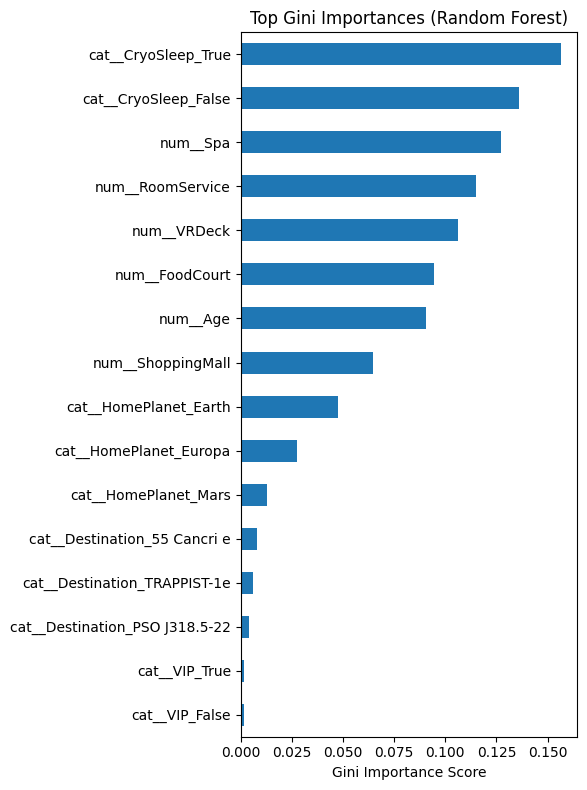

In [76]:
# Ensure feature names are correct after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the best model (Random Forest)
importances = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)

# Display top 10 features
display(importances.head(10))

# Plot top 20 features
plt.figure(figsize=(6, 8))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top Gini Importances (Random Forest)")
plt.xlabel("Gini Importance Score")
plt.tight_layout()
plt.show()


Explainable AI Methods

## Explainable ai methods

### Subtask:
Apply Explainable AI methods (SHAP and LIME) to the best performing model to understand feature importance and individual predictions.


In [38]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d379c69d9c63968688942c185243d3c7259f082411157063462006e9b94e6b9e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [39]:
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

## Explainable ai methods

### Subtask:
Apply Explainable AI methods (SHAP and LIME) to the best performing model to understand feature importance and individual predictions.


<Figure size 1200x1200 with 0 Axes>

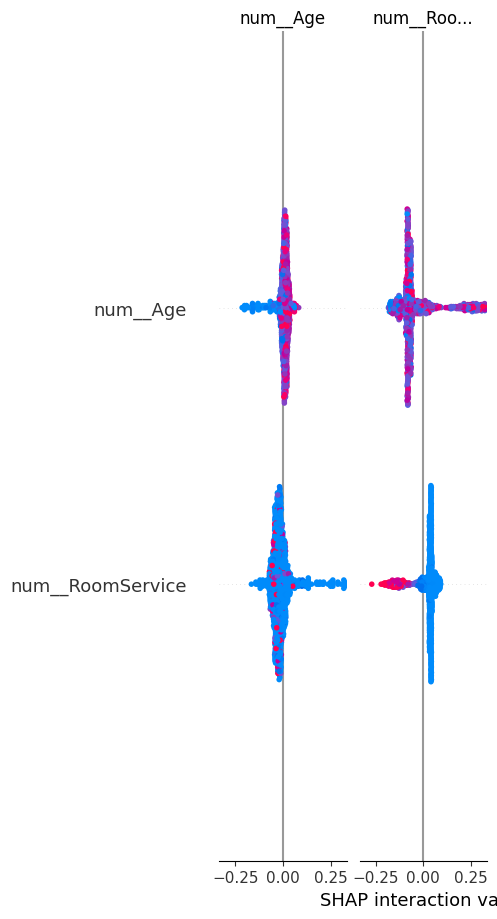

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

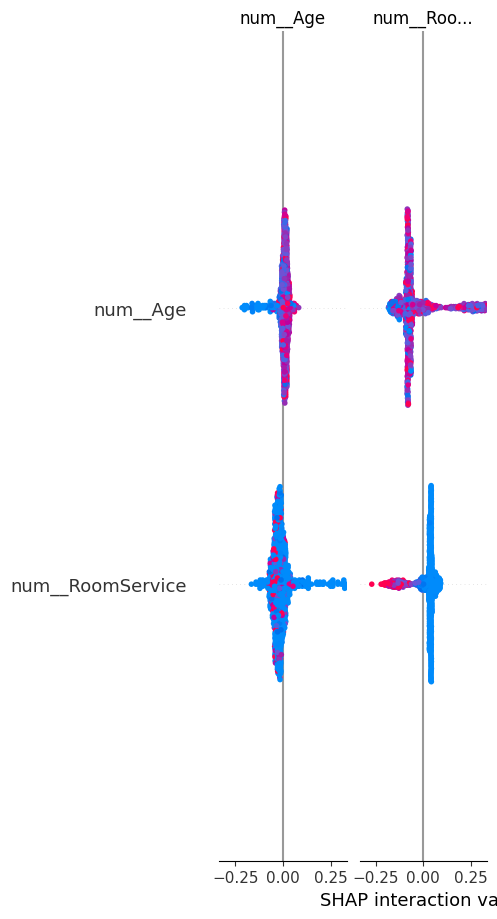

In [102]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert X_train to dense array if needed
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train

# Create DataFrame with feature names
X_train_df = pd.DataFrame(X_train_dense, columns=preprocessor.get_feature_names_out())

# Sample 1000 rows (or fewer if dataset is smaller)
n_samples = min(1000, len(X_train_df))
sample_idx = np.random.choice(X_train_df.index, size=n_samples, replace=False)
X_sample = X_train_df.loc[sample_idx]

# Create TreeExplainer for Random Forest
explainer = shap.TreeExplainer(best_model)  # best_model is Random Forest

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Plot summary bar (global importance by mean |SHAP|)
plt.figure(figsize=(12, 12))  # Width, Height in inches
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)
plt.savefig("shap_summary_bar.png", dpi=300, bbox_inches='tight')

# Plot beeswarm (distribution of SHAP values per feature)
plt.figure(figsize=(12, 8))  # Width, Height in inches
shap.summary_plot(shap_values, X_sample, max_display=10)


In [93]:
# Attempt the SHAP Force Plot again, correcting the indexing based on the shape (1, 16, 2)

# Select a random index from the sample for individual explanation
random_instance_idx = np.random.choice(X_sample.index)
instance_to_explain = X_sample.loc[random_instance_idx].values # Convert to numpy array

# Calculate SHAP values for the single instance
shap_values_instance = explainer.shap_values(instance_to_explain.reshape(1, -1))

# Assuming shap_values_instance has shape (1, 16, 2)
# Extract the SHAP values for the first instance (index 0) and for class 1 (index 1)
shap_values_for_force_plot = shap_values_instance[0, :, 1] # Select the first instance (0), all features (:), and class 1 (1)

# Get the expected value for the positive class (class 1)
expected_value = explainer.expected_value[1]

print(f"\n--- Generating SHAP Force Plot for instance at index {random_instance_idx} (Attempt 5) ---")
print(f"Shape of instance_to_explain: {instance_to_explain.shape}")
print(f"Shape of shap_values_instance (after explainer): {shap_values_instance.shape}")
print(f"Shape of shap_values_for_force_plot: {shap_values_for_force_plot.shape}")
print(f"Expected value for class 1: {expected_value}")

# Generate a SHAP force plot for the selected instance
# Need the original feature values for the force plot
original_instance_features = X_sample.loc[random_instance_idx]

shap.force_plot(expected_value, shap_values_for_force_plot, original_instance_features,
                feature_names=preprocessor.get_feature_names_out())

print("SHAP Force Plot generation attempted.")


--- Generating SHAP Force Plot for instance at index 3897 (Attempt 5) ---
Shape of instance_to_explain: (16,)
Shape of shap_values_instance (after explainer): (1, 16, 2)
Shape of shap_values_for_force_plot: (16,)
Expected value for class 1: 0.5002985433626977
SHAP Force Plot generation attempted.


In [96]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Randomly choose one instance to explain from X_sample
random_instance_idx = np.random.choice(X_sample.index)
instance_to_explain = X_sample.loc[random_instance_idx]

# Compute SHAP values for the instance (reshape needed)
shap_values_instance = explainer.shap_values(instance_to_explain.values.reshape(1, -1))

# Extract SHAP values for class 1 (Transported=True)
shap_values_for_force_plot = shap_values_instance[0, :, 1] # class 1, instance 0

# Get expected value for class 1
expected_value = explainer.expected_value[1]

# Display diagnostic info
print(f"\n--- SHAP Force Plot for Instance Index {random_instance_idx} ---")
print(f"Instance shape: {instance_to_explain.shape}")
print(f"SHAP values shape: {shap_values_for_force_plot.shape}")
print(f"Expected value (class 1): {expected_value:.4f}")

# --- Generate Force Plot ---
shap.initjs()
shap.force_plot(expected_value,
                shap_values_for_force_plot,
                instance_to_explain,
                feature_names=preprocessor.get_feature_names_out())



--- SHAP Force Plot for Instance Index 6045 ---
Instance shape: (16,)
SHAP values shape: (16,)
Expected value (class 1): 0.5003



--- Generating LIME explanation for instance at index 2960 ---


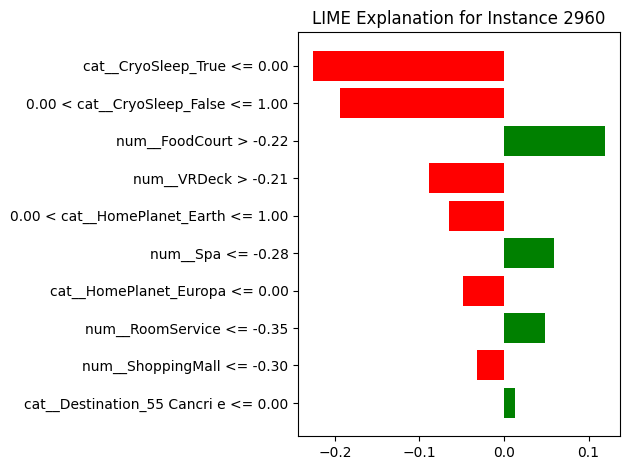

LIME explanation generation attempted.


In [94]:
# Apply LIME for individual instance explanation

# Create a LIME explainer object
# Need to provide training data, feature names, and class names
# The training data for the explainer should be the dense, preprocessed training data.
explainer_lime = LimeTabularExplainer(
    training_data=X_train_df.values, # Use the DataFrame values (numpy array)
    feature_names=X_train_df.columns.tolist(), # Use the feature names from the DataFrame
    class_names=['Not Transported', 'Transported'], # Class names for the target variable
    mode='classification' # Specify classification task
)

# Select an instance to explain using LIME (can use the same instance index as SHAP or a new one)
# Let's use the same random index as before, or select a new one
# random_instance_idx is from the X_sample indices, need to get the corresponding index in X_train_df
# Since X_sample is a slice of X_train_df, the index from X_sample directly corresponds to X_train_df index.
# Let's use the same random_instance_idx from the last successful SHAP plot or pick a new one from X_train_df
random_instance_for_lime_idx = np.random.choice(X_train_df.index)
instance_to_explain_lime = X_train_df.loc[random_instance_for_lime_idx]

print(f"\n--- Generating LIME explanation for instance at index {random_instance_for_lime_idx} ---")

# Generate explanation for the instance
# Need to pass the instance values as a numpy array
explanation = explainer_lime.explain_instance(
    data_row=instance_to_explain_lime.values,
    predict_fn=best_model.predict_proba, # LIME needs probability predictions
    num_features=10 # Number of features to include in the explanation
)

# Visualize the explanation
explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {random_instance_for_lime_idx}')
plt.tight_layout()
plt.show()

print("LIME explanation generation attempted.")

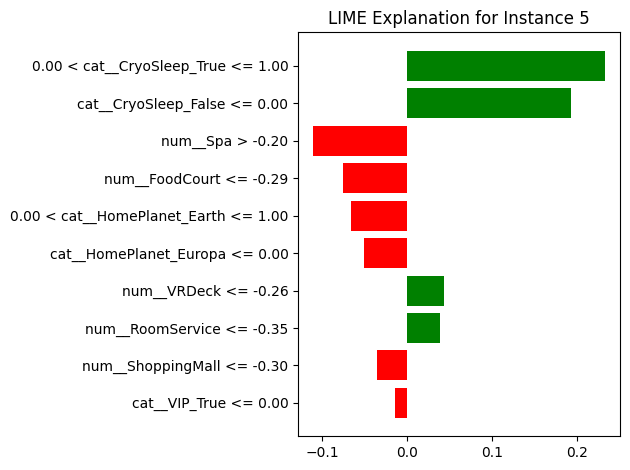

In [98]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Convert X_train and X_val to dense if sparse
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Class names (should be ['0', '1'] for binary classification)
class_names = ['Not Transported', 'Transported']

# Initialize the LIME explainer
lime_exp = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Pick a row from validation set
row_id = 5  # or any valid index < len(X_val_dense)
exp = lime_exp.explain_instance(
    data_row=X_val_dense[row_id],
    predict_fn=best_model.predict_proba,
    num_features=10
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)

# Optional: Plot as matplotlib figure
fig = exp.as_pyplot_figure()
fig.tight_layout()
plt.title("LIME Explanation for Instance {}".format(row_id))
plt.show()
